# **Equity option pricing & delta-hedging simulation**

## **Introduction and Objectives**

The objective of this notebook is to study the **pricing and hedging of vanilla equity options** using classical quantitative finance models. We start by implementing **analytical and numerical pricing methods**, and progressively build a **delta-hedging framework** to analyze the performance of hedged portfolios under **stochastic stock price dynamics**.

We first introduce the **Black–Scholes–Merton (BSM) model** as a benchmark for pricing **European options** and computing **analytical Greeks**. We then extend the pricing framework using **binomial tree models (CRR)**, allowing us to handle **American-style options** and **discrete dividends**, which cannot be treated analytically within the standard BSM setting.

Next, we implement **Monte Carlo simulations** to generate stock price paths under a **geometric Brownian motion**. These simulated paths are used to dynamically rebalance a **delta-hedged portfolio**, allowing us to study the **time evolution of the portfolio value** and to analyze the **distribution of final hedging profits and losses (PnL)**.

Finally, we focus on **visualization and convergence analysis**, examining how the **stock price**, **option delta**, and **delta-hedged portfolio** evolve along multiple simulated paths. We also investigate the impact of **time discretization** and the **number of Monte Carlo paths** on the stability and accuracy of the **hedging strategy**.

This notebook aims to provide both a **theoretical understanding** and a **practical implementation** of option pricing and delta hedging, highlighting the **strengths and limitations** of each numerical method in a **realistic equity derivatives setting**.


## 1. Importation

#### 1.1. Import modules

In [1]:
from math import log, sqrt, exp, erf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import norm

#### 1.2. Input Data

The user of the model can choose to import his data by calling the function `import_data()`. 

In [2]:
def import_data():
    S0 = float(input("Enter S0 price :"))
    r = float(input("Enter risk-free interest rate r (in decimal) : "))
    dividend_yield = float(input("Enter dividend yield : "))
    T = float(input("Enter time to maturity : "))/360
    K = float(input("Enter strike price K : "))
    sigma = float(input("Enter volatility (in decimal) : "))
    option_type = input("Enter option type (call/put) : ").lower()
    option_style = input("Enter option style (1: european/ 2 : american) : ").lower()

## 2. Pricing european options - Black-Scholes Merton model

The Black-Scholes-Merton (BSM) model is a cornerstone of modern quantitative finance, providing a closed-form solution for pricing European options under the assumption of log-normal stock price dynamics and continuous hedging. Implementing the BSM model at the start of this notebook serves several purposes. First, it establishes a reference benchmark for option prices and deltas, which is crucial when testing and validating numerical methods such as Monte Carlo simulations or binomial trees. Second, it allows us to compute the theoretical sensitivities (Greeks) like delta and gamma, which are essential for delta-hedging and risk management exercises. Finally, implementing BSM helps develop an intuitive understanding of how model parameters—such as volatility, interest rate, and time to maturity—affect option prices, providing a foundation for more advanced models and simulation-based hedging strategies explored later in this notebook.

#### 2.1. Code

This block of code implements the core components of the Black–Scholes–Merton (BSM) framework for pricing European options and computing their main sensitivities. The functions d1 and d2 correspond to the standard analytical terms appearing in the Black–Scholes formula. A small lower bound is imposed on the maturity 𝑇 to avoid numerical instabilities such as division by zero when the option approaches maturity.

The function `price_bsm` computes the theoretical price of a European call or put option using the closed-form Black–Scholes formula. A restriction is explicitly enforced to prevent pricing American options, as the BSM model does not account for early exercise features.

The function `delta_bsm` returns the Delta of the option, which measures the sensitivity of the option price with respect to changes in the underlying asset price. Delta plays a central role in hedging strategies, as it determines the number of shares required to replicate the option locally.

Finally, the function `gamma_bsm` computes the Gamma of the option, which captures the curvature of the option price with respect to the underlying asset. Gamma quantifies how Delta itself changes when the underlying price moves, and is therefore essential for understanding the limitations of pure delta hedging.

Together, these functions provide a complete analytical benchmark for option pricing and risk management under the Black–Scholes assumptions.

In [3]:
def d1(S0,K,T,r,sigma):
    T = max(T, 1e-10)  # Prevent division by zero
    return ( np.log(S0/K) + (r+(sigma**2)/2)*T ) / (sigma*np.sqrt(T))

def d2(S0,K,T,r,sigma):
    T = max(T, 1e-10)  # Prevent division by zero
    return d1(S0,K,T,r,sigma) - sigma*np.sqrt(T)

def price_bsm(S0,K,T,r,sigma,option_type='call',option_style='european'):
    if option_style == 'american':
        raise ValueError("BSM model is only for European options.")
    
    else :     
        if option_type == "call":
            price=S0*norm.cdf(d1(S0,K,T,r,sigma))-K*np.exp(-r*T)*norm.cdf(d2(S0,K,T,r,sigma))
        elif option_type == "put":
            price=K*np.exp(-r*T)*norm.cdf(-d2(S0,K,T,r,sigma))-S0*norm.cdf(-d1(S0,K,T,r,sigma))
        return price

def delta_bsm(S0,K,T,r,sigma,option_type='call'):
    if option_type == "call":
        delta=norm.cdf(d1(S0,K,T,r,sigma))
    elif option_type == "put":
        delta=norm.cdf(d1(S0,K,T,r,sigma))-1
    return delta

def gamma_bsm(S0,K,T,r,sigma):
    return norm.pdf(d1(S0,K,T,r,sigma)) / (S0*sigma*np.sqrt(T))

#### 2. Test

In [4]:
# 1) Parameters

S0 = 110
K = 100
T = 1
r = 0.05
sigma = 0.2
steps = 50
option_type = 'call'
option_style = 'european'

# 2) Calculus

print(price_bsm(S0, K, T, r, sigma, option_type, option_style))
print(delta_bsm(S0, K, T, r, sigma, option_type))
print(gamma_bsm(S0, K, T, r, sigma))

17.66295374059044
0.7957541713095866
0.012886510906085861


## 3. Binomial tree pricing - Cox-Ross-Rubinstein

The Cox-Ross-Rubinstein (CRR) binomial tree is a versatile numerical method for pricing options, particularly useful when dealing with American-style options, discrete dividends, or other path-dependent features where closed-form solutions like Black-Scholes-Merton do not exist. Implementing the CRR model in this notebook allows us to approximate the evolution of the underlying asset over discrete time steps, compute option values at each node, and derive the corresponding deltas for hedging. It provides an intuitive, step-by-step framework to understand early exercise decisions and the impact of discrete dividends. Additionally, the CRR tree serves as a bridge between analytical models like BSM and simulation-based approaches such as Monte Carlo, enabling us to validate and compare different numerical techniques for option pricing and risk management.

#### 3.1. Code

The `price_binomial_euro` function prices a European option using the Cox–Ross–Rubinstein (CRR) binomial tree model. The underlying asset price evolves through discrete up and down movements over a finite number of time steps, with probabilities chosen under the risk-neutral measure. The option payoff is computed at maturity and then discounted backward through the tree to obtain the option price at time zero.

In [5]:
def price_binomial_euro(
    S0,K,T,r,sigma,steps,
    option_type="call",
    dividend_yield=0):

    # Cas où l'échéance est immédiate
    if T <= 0:
        if option_type == "call":
            return max(0, S0 - K)
        else:
            return max(0, K - S0)    

    #1 - Paramètres du modèle
    
    dt = T/steps
    discount_factor = exp(-r*dt)
    u = exp(sigma*sqrt(dt))
    d = exp(-sigma*sqrt(dt))
    p = (exp((r-dividend_yield)*dt)-d)/(u-d)
    
    #2 - Calcul des prix à l'échéance et des payoffs
    
    ST = np.array([S0 * (u**i) * (d**(steps-i)) for i in range (steps+1)]) # Terminal prices St
    
    if option_type=="call":
        VT = np.maximum(0,ST - K)
    elif option_type=="put":
        VT = np.maximum(0, K-ST)
    else:
        raise ValueError("Please enter a valid option type ('call/put')'")

    #3 - Récursion pour remonter l'arbre
    for i in range (steps-1,-1,-1):
        VT = discount_factor * (p * VT[1:i+2] + (1-p) * VT[0:i+1])
    
    #4 - Prix de l'option au temps 0
    return VT[0]

The `price_binomial_US` function prices an American option using the CRR binomial tree model. At each node, the option value is computed as the maximum between the continuation value and the immediate exercise payoff, allowing for early exercise. The backward induction therefore incorporates the option’s exercise flexibility, which is a key feature of American-style contracts.

In [6]:
def price_binomial_US(
    S0,K,T,r,sigma,steps,
    option_type="call"):
    
    # If maturity is immediate
    if T <= 0:
        if option_type == "call":
            return max(0, S0 - K)
        else:
            return max(0, K - S0)
    
    #1 - Parameters of the model
    
    dt = T/steps
    discount_factor = exp(-r*dt)
    u = exp(sigma*sqrt(dt))
    d = exp(-sigma*sqrt(dt))
    p = (exp(r*dt)-d)/(u-d)
    
    #2 - Payoffs at maturity
    ST = np.array([S0 * (u**i) * (d**(steps-i)) for i in range (steps+1)])
    
    if option_type=="call":
        VT = np.maximum(0,ST - K)
    elif option_type=="put":
        VT = np.maximum(0, K-ST)
    else:
        raise ValueError("Please enter a valid option type 'call/put'")

    #3 - Recursion to go back through the tree
    for i in range (steps-1,-1,-1):
        St= S0 * (u**np.arange(i+1)) * (d**(i-np.arange(i+1)))
        Vt = discount_factor * (p * VT[1:i+2] + (1-p) * VT[0:i+1])
        if option_type=="call":
            VT = np.maximum(Vt, St -K)
        else:
            VT = np.maximum(Vt, K-St) 
    
    #4 - Option price at time 0
    return VT[0]

The following function `price_binomial_with_dividend` extends the CRR binomial tree model to price options with a discrete dividend paid at a known date T1. The underlying price tree is first constructed forward, and the dividend amount is subtracted from the stock price at the dividend date. The option value is then obtained by backward induction, allowing for early exercise in the American case. This approach makes it possible to price both European and American options while explicitly accounting for the impact of discrete dividends on the underlying asset dynamics.

In [7]:
def price_binomial_with_dividend(
    S0, K, T, r, sigma, steps,
    div, T1,
    option_type="call",
    option_style="european"
):
    
    # If maturity is immediate
    if T <= 0:
        if option_type == "call":
            return max(0, S0 - K)
        else:
            return max(0, K - S0)
    
    # 1) Parameters of the model
    dt = T / steps
    u = exp(sigma * sqrt(dt))
    d = exp(-sigma * sqrt(dt))
    p = (exp(r * dt) - d) / (u - d)
    discount = exp(-r * dt)

    # 2) Stock price tree
    S = np.zeros((steps + 1, steps + 1))
    S[0, 0] = S0

    for i in range(1, steps + 1):
        for j in range(i + 1):
            if j == 0:
                S[i, j] = S[i - 1, j] * d
            elif j == i:
                S[i, j] = S[i - 1, j - 1] * u
            else:
                S[i, j] = S[i - 1, j - 1] * u

        # Adjust for dividend payment
    if T1 is not None and (i - 1) * dt < T1 <= i * dt:
        S[i, :i + 1] -= div

    # 3) Option value at maturity
    V = np.zeros_like(S)

    if option_type == "call":
        V[steps, :steps + 1] = np.maximum(S[steps, :steps + 1] - K, 0)
    elif option_type == "put":
        V[steps, :steps + 1] = np.maximum(K - S[steps, :steps + 1], 0)
    else:
        raise ValueError("option_type doit être 'call' ou 'put'")

    # 4) Recursion to go back through the tree
    for i in range(steps - 1, -1, -1):
        for j in range(i + 1):
            continuation = discount * ( p * V[i + 1, j + 1] + (1 - p) * V[i + 1, j])

            if option_style == "american":
                if option_type == "call":
                    V[i, j] = max(continuation, S[i, j] - K)
                else:
                    V[i, j] = max(continuation, K - S[i, j])
            else:
                V[i, j] = continuation

    # 5) Option price at time t = 0
    return V[0, 0]

#### 3.2. Test

This block sets the option parameters and computes prices using three binomial models: European, American, and with discrete dividends, illustrating the impact of exercise style and dividends on option valuation.

This section computes option prices under different assumptions.

The expected option prices depend on the type of option, its style, and whether dividends are present. For European options, the price of a call or put reflects the discounted value of its payoff at maturity; early exercise is not allowed, so American and European calls without dividends have the same price. When a discrete dividend is paid, the call price decreases (because the stock drops), while the put price increases. For American options, early exercise may be optimal: a call with a dividend can be worth more than its European counterpart, and a put is always at least as valuable as the European put.

In [8]:
# 1) Parameters

S0 = 110
K = 100
T = 1
r = 0.05
sigma = 0.2
steps = 50
option_type = 'call'
option_style = 'american'

# 2) Calculus

print(price_binomial_euro(S0, K, T, r, sigma, steps, option_type=option_type))
print(price_binomial_US(S0, K, T, r, sigma, steps, option_type='call'))
print(price_binomial_with_dividend(S0, K, T, r, sigma, steps,
                                  div=2, T1=0.5,
                                  option_type=option_type,
                                  option_style=option_style))

17.685078603474018
17.685078603474018
17.685078603474032


## 4. Greeks

Calculating the Greeks—Delta, Gamma, Vega, Theta, and Rho—is essential for understanding and managing the sensitivities of an option’s value to changes in the underlying parameters. In this notebook, we implement functions to compute Delta and Gamma at any given point in time, which are particularly important for delta-hedging and risk management. The option style (European or American) plays a crucial role in these calculations: for European options, closed-form approximations such as the Black-Scholes-Merton formula can be used, whereas for American options, numerical methods like the CRR binomial tree are necessary to account for the possibility of early exercise. By defining these functions, we can dynamically evaluate hedging strategies across different option styles and market scenarios, providing a more comprehensive framework for risk analysis.

#### 4.1. Code

The following function computes the delta of an option, i.e., the sensitivity of its price to small changes in the underlying asset S0. If the option is European without dividends, the analytical Black-Scholes delta is used. For American options without dividends, a central finite difference approximation is applied using the binomial tree price. If there are discrete dividends or American-style options with dividends, the function uses a binomial tree that accounts for dividends and computes delta numerically via a small upward and downward shift in the underlying. The epsilon parameter controls the size of this shift.

In [9]:
def delta(
    S0,K,T,r,sigma,
    option_type='call', 
    option_style='european',
    epsilon=1e-3, 
    discret_div=0,
    T1=None):

    T = max(T, 1e-10)  # Prevent division by zero

    if option_style == 'european' or option_style == '1' and discret_div == 0:
        return delta_bsm(S0,K,T,r,sigma,option_type)
    
    elif option_style == 'american' or option_style == '2' and discret_div == 0:    
        V_plus=price_binomial_US(
            S0+epsilon,K,T,r,sigma,
            steps=100,
            option_type=option_type)
        
        V_minus=price_binomial_US(
            S0-epsilon,K,T,r,sigma,
            steps=100,
            option_type=option_type)
        
        d = (V_plus - V_minus) / (2*epsilon)
        return d
    
    else: 
        V_plus = price_binomial_with_dividend(
            S0+epsilon, K, T, r, sigma, 100, discret_div, T1,
            option_type,
            option_style
        )

        V_minus = price_binomial_with_dividend(
            S0-epsilon, K, T, r, sigma, 100, discret_div, T1,
            option_type,
            option_style
        )
        
        d = (V_plus - V_minus) / (2*epsilon)
        return d
        

The following function calculates the gamma of an option, which measures the sensitivity of the option's delta to changes in the underlying asset S0. For European options without dividends, the analytical Black-Scholes gamma is used. For American options without dividends, gamma is computed numerically using a central finite difference on the deltas obtained from a binomial tree. In the presence of discrete dividends or American-style options with dividends, the function uses a binomial tree that incorporates dividends and computes gamma numerically via finite differences on delta. The epsilon parameter controls the small shifts in S0 used for the approximation.

In [10]:
def gamma(
    S0,K,T,r,sigma,
    option_type='call', 
    option_style='european', 
    discret_div=0,
    epsilon=1e-3,
    T1=None):

    T = max(T, 1e-10)  # Prevent division by zero

    if option_style == 'european' and discret_div == 0:
        return gamma_bsm(S0,K,T,r,sigma)
    
    elif option_style == 'american' and discret_div == 0:    
        V_plus=price_binomial_US(
            S0+epsilon,K,T,r,sigma,
            steps=100,
            option_type=option_type)
        
        V_minus=price_binomial_US(
            S0-epsilon,K,T,r,sigma,
            steps=100,
            option_type=option_type)
        
        V_0=price_binomial_US(
            S0,K,T,r,sigma,
            steps=100,
            option_type=option_type)

        delta_plus = (V_plus - V_0) / (2 * epsilon)
        delta_minus = (V_0 - V_minus) / (2 * epsilon)

        g = (delta_plus - delta_minus) / (2 * epsilon)
        return g
    
    else:
        V_plus = price_binomial_with_dividend(
            S0+epsilon, K, T, r, sigma, 100, discret_div, T1,
            option_type,
            option_style
        )

        V_minus = price_binomial_with_dividend(
            S0-epsilon, K, T, r, sigma, 100, discret_div, T1,
            option_type,
            option_style
        )
        
        V_0 = price_binomial_with_dividend(
            S0, K, T, r, sigma, 100, discret_div, T1,
            option_type,
            option_style
        )

        delta_plus = (V_plus - V_0) / (2 * epsilon)
        delta_minus = (V_0 - V_minus) / (2 * epsilon)

        g = (delta_plus - delta_minus) / (2 * epsilon)
        return g

#### 4.2. Test

The `delta` function measures the sensitivity of an option's price to changes in the underlying asset. For a call option, delta is positive, increasing as the option becomes more in-the-money, and approaching 1 for deep in-the-money calls. For a put option, delta is negative, approaching -1 for deep in-the-money puts.

The `gamma` function measures the sensitivity of delta to changes in the underlying. Gamma is always positive for both calls and puts. It is largest for at-the-money options and decreases as the option becomes deep in- or out-of-the-money.

These behaviors are consistent across European and American options, with the caveat that American options may exhibit slightly higher delta or gamma near potential early exercise points. Dividends or discrete payouts can also affect both Greeks by shifting option value and sensitivities.

In [11]:
print(delta(90,100,1,0.05,0.2,'call','american'))
print(gamma(90,100,1,0.05,0.2,'call','american'))

0.44081466740575337
4.440892098500626e-10


## 5. Monte Carlo simulation

Monte Carlo simulation is a versatile tool for pricing options and evaluating hedging strategies under stochastic market dynamics. Unlike analytical formulas or lattice methods, Monte Carlo allows us to simulate numerous possible paths for the underlying asset, capturing the effects of volatility, interest rates, and dividends over time. This is particularly useful for complex options, path-dependent features, or American-style options where early exercise may occur. In this notebook, we use Monte Carlo simulations to model the evolution of the underlying asset and to implement delta-hedging strategies across multiple simulated scenarios, enabling us to analyze the distribution of hedging PnL and assess the effectiveness of different risk management approaches.

The `simulate_MC_path` function generates a single Monte Carlo path for the underlying asset price over time, using a geometric Brownian motion (GBM) model.

*At each step:*  
    The price evolves according to the standard GBM formula.  
    This models the continuous stochastic evolution of the asset under a risk-neutral measure.  
    If a discrete dividend is scheduled at time T1, it is subtracted from the asset price at the corresponding step.  

The function returns the full path of prices from t = 0 to the maturity, which can then be used for pricing, hedging, or visualizing stochastic trajectories of the underlying.

In [12]:
def simulate_MC_path(S0, T, r, sigma, steps, div=0, T1=0):

    dt = T / steps
    S_path = [S0]
    for i in range(1, steps+1):
        S_prev = S_path[-1]
        Z = np.random.randn()  # normal random variable
        S_t = S_prev * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
        
        # Discrete dividend application if needed
        if div > 0 and (i-1)*dt < T1 <= i*dt:
            S_t -= div
            
        S_path.append(S_t)
    return np.array(S_path)

## 6. Delta-hedged portfolios

### 6.1. Simple delta-hedging

Delta hedging is a fundamental risk management technique used to neutralize the sensitivity of an option’s value to small movements in the underlying asset. In this notebook, we implement a Monte Carlo-based delta hedging strategy that rebalances a portfolio over the life of the option. Our initial version focuses on computing the portfolio values at the final time T for multiple simulated paths of the underlying asset. This approach allows us to analyze the distribution of the terminal hedged PnL across different market scenarios, providing insights into the effectiveness of the delta hedge while keeping the computational complexity manageable. Although intermediate portfolio values are not tracked in this version, the final PnL distribution is sufficient to evaluate hedging performance.

The `delta_hedge_MC` function implements a **Monte Carlo delta hedging strategy** for a given option. The main steps are:  

1. **Simulation of underlying paths**: For each of the `N_paths` Monte Carlo simulations, the function generates a possible trajectory of the underlying asset price \(S_t\) over the `steps` time intervals, accounting for possible discrete dividends.  

2. **Initial hedge setup**: At the start, the option's **delta** is computed (using either **BSM** for European options or **binomial methods** for American options), and the portfolio is initialized with a **cash position** corresponding to the option value minus the cost of holding the delta units of the underlying.  

3. **Dynamic rebalancing**: At each time step:
   - Interest accrues on the **cash component**.
   - If a discrete **dividend** occurs, it is added to cash according to the previous delta.
   - The **delta** is recalculated for the updated underlying price and remaining time.
   - The portfolio is **rebalanced** to match the new delta, adjusting the cash accordingly.
   - The **total portfolio value** is updated as cash plus the delta-weighted underlying position.  

4. **Recording results**: Only the **final portfolio value** (**PnL**) at maturity is kept for each path. The function returns a **NumPy array** of these final values across all simulated paths.  

**Key points**:  
- This approach models the **hedging performance** under realistic **stochastic asset paths**.  
- The function handles both **European and American options**, as well as **discrete dividends**.  
- It currently stores only the **end-of-period PnL**, not the full time series of portfolio values.


In [13]:
def delta_hedge_MC(
    S0, K, T, r, sigma, 
    steps=50, 
    option_type='call', 
    option_style='european', 
    epsilon=1e-3, 
    div=0, T1=0, 
    N_paths=100
):
    # 1) Parameters of the model
    
    dt = T / steps
    all_portfolios = []
    
    # 2) Simulating N_paths stock price paths
    
    for n in range(N_paths):
        S_path = simulate_MC_path(S0, T, r, sigma, steps, div, T1)
        
        dt = T / steps
        
        Delta_prev = delta(
            S0, K, T, r, sigma,
            option_type,
            option_style,
            epsilon,
            div,
            T1=T1
        )   
    
    # 3) Hedging along the path
        # 3a) Initial parameter
        V0 = price_binomial_with_dividend(S0, K, T, r, sigma, steps, div, T1, option_type, option_style)
        
        cash = V0 - Delta_prev * S0
        
        portfolio = []

        # 3b) Creating the portfolio value at each time step
        for i in range(1, steps+1):
            S_t = S_path[i]
            t_remain = T - i*dt
            
            cash*= np.exp(r * dt) # interest on cash
            
            if div!=0 and T1 is not None:
                if (i-1)*dt < T1 <= i*dt:
                    cash += Delta_prev * div
                
            Delta_t = delta(S_t, K, t_remain, r, sigma,
                            option_type=option_type,
                            option_style=option_style,
                            epsilon=epsilon)

        # 3c) Rebalancing the portfolio
            cash -= (Delta_t - Delta_prev) * S_t

        # 3d) Total portfolio value
            portfolio_value = cash + Delta_t * S_t
            portfolio.append(portfolio_value)
            
            Delta_prev = Delta_t

        # 3e) At maturity, we compute the final PnL
        all_portfolios.append(portfolio[-1])

    return np.array(all_portfolios)


In order to better visualize the **effectiveness of the delta hedging strategy**, we compute the **PnL (profit and loss)** of the delta-hedged portfolio across multiple Monte Carlo paths.  

The code above simulates `500` paths of the underlying asset using `delta_hedge_MC`, with an **American call option** including a discrete **dividend** at `T1=0.5`.  

We then compute basic statistics of the **final PnL** across all paths:  

- **Mean PnL**: provides an average performance of the hedge.  
- **Standard deviation (Std PnL)**: measures the variability of the hedging results.  
- **Minimum and Maximum PnL**: show the worst and best outcomes across simulations.  

Finally, we plot the **distribution of the delta-hedged PnL** across all paths to visualize the spread and risk associated with the hedging strategy. This helps assess how well the delta hedge performs in practice under stochastic price movements.

Mean PnL: 18.914041791587717
Std PnL : 20.21825543247654
Min PnL : -2.85160647606277
Max PnL : 100.09381657023947


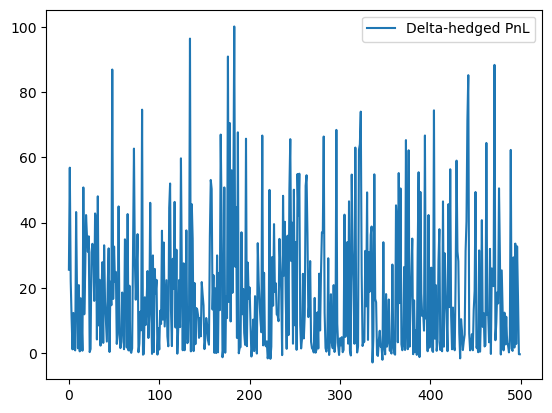

In [14]:
pnl = delta_hedge_MC(S0=110, K=100, T=1, r=0.05, sigma=0.2,
                    steps=50, option_type='call', option_style='american',
                    epsilon=1e-4, div=2, T1=0.5, N_paths=500)
print("Mean PnL:", pnl.mean())
print("Std PnL :", pnl.std())
print("Min PnL :", pnl.min())
print("Max PnL :", pnl.max())

plt.plot(pnl, label='Delta-hedged PnL')
plt.legend()
plt.show()

### 6.2. Full path tracking

**Monte Carlo Simulation of Stock Paths and Delta-Hedged Portfolios**

In this section, we simulate multiple stock price paths using Monte Carlo to account for the stochastic nature of the underlying. For each path, we compute the corresponding **delta** of the option at each time step and construct a **delta-hedged portfolio**. This allows us to visualize how the stock price, the hedge (delta), and the portfolio evolve over time along several simulated scenarios. By plotting a subset of paths, we can get an intuitive understanding of the dynamics of both the underlying asset and the hedging strategy, as well as the variability in the resulting portfolio values.

To better understand the behavior of the delta-hedged portfolio, we extended our Monte Carlo simulation to track the evolution of three key variables over time: the underlying asset price, the delta of the option, and the total value of the delta-hedged portfolio. By simulating 50 possible paths of the underlying asset, we can visualize how the hedge adjusts dynamically in response to market movements. This detailed view allows us to inspect the time evolution of the portfolio, observe the effectiveness of delta rebalancing at each step, and identify scenarios where the hedge might underperform. Visualizing multiple paths also provides intuition about the variability of both the underlying and the hedged portfolio, highlighting the stochastic nature of option risk and hedging.

The function `delta_hedge_all_portfolios` extends the previous Monte Carlo delta-hedging implementation by **storing detailed information at each time step** for every simulated path.  

For each of the `N_paths` Monte Carlo simulations, it generates a stock price path (`S_path`) using `simulate_MC_path`. At each node along the path, it computes the **current delta** of the option, adjusts the hedge accordingly, accrues interest on the cash position, and accounts for discrete dividends if present. This allows the function to track the **entire evolution of the delta-hedged portfolio**, not just the final PnL.  

The returned structure includes, for each path:
- `path`: the simulated stock prices over time,
- `portfolio_values`: the value of the delta-hedged portfolio at each time step,
- `deltas`: the delta of the option along the path,
- `final_pnl`: the terminal profit and loss of the hedge.

This more detailed approach addresses limitations of the previous implementation, where only the final portfolio values were returned. However, it comes with **increased computational cost**, especially for large numbers of steps or paths, as delta computations and portfolio rebalancing are performed at every node for each path. This explains why the earlier version could take a long time to execute for fine discretizations or high path counts. To improve velocity of the model, vectorization is used. 

In [15]:
def delta_hedge_all_portfolios(
    S0, K, T, r, sigma, 
    steps=50, 
    option_type='call', 
    option_style='european', 
    epsilon=1e-3, 
    div=0, T1=0, 
    N_paths=100):

    # 1) Parameters of the model    
    dt = T / steps
    all_results = []
    
    # 2) Simulating N_paths stock price paths
    for n in range(N_paths):
        S_path = simulate_MC_path(S0, T, r, sigma, steps, div, T1)
        
        # Initial position
        Delta_prev = delta(
            S0, K, T, r, sigma,
            option_type,
            option_style,
            epsilon,
            div,
            T1=T1
        )   

        V0 = price_binomial_with_dividend(S0, K, T, r, sigma, steps, div, T1, option_type, option_style)
        
        cash = V0 - Delta_prev * S0
        portfolio_values = [V0]
        deltas_path = [Delta_prev]
        
        for i in range(1, steps + 1):
            S_t = S_path[i]
            t_remain = T - i * dt
            
            # Accrue interest on cash
            cash *= np.exp(r * dt)
            
            # Handle discrete dividend
            if div != 0 and T1 is not None:
                if (i - 1) * dt < T1 <= i * dt:
                    cash += Delta_prev * div
            
            # Compute new delta at this node
            Delta_t = delta(S_t, K, t_remain, r, sigma,
                           option_type=option_type,
                           option_style=option_style,
                           epsilon=epsilon)
            
            # Rebalance: adjust hedge
            cash -= (Delta_t - Delta_prev) * S_t
            
            # Portfolio value at this node
            portfolio_value = cash + Delta_t * S_t
            portfolio_values.append(portfolio_value)
            deltas_path.append(Delta_t)
            
            Delta_prev = Delta_t
        
        # Final PnL
        final_payoff = max(0, S_path[-1] - K) if option_type == 'call' else max(0, K - S_path[-1])
        final_pnl = portfolio_values[-1] - final_payoff
        
        all_results.append({
            'path': S_path,
            'portfolio_values': portfolio_values,
            'deltas': deltas_path,
            'final_pnl': final_pnl
        })
    
    return all_results


## 7. Visualization of results

### 7.1. Visualization of delta and gamma following St Monte Carlo simulation

To **analyze the dynamics of the underlying asset and its sensitivities**, we simulate a single Monte Carlo path of the underlying price `S_t` over `50` time steps with a discrete dividend at `T1=0.5`.  

We then compute the **Delta** and **Gamma** along this path for an option with strike `K=125` using the previously defined functions.  

The resulting plot shows:

- The **blue curve**: the evolution of the underlying asset `S_t`.  
- The **green curve**: the Delta, representing the sensitivity of the option price to small changes in `S_t`.  
- The **red curve**: the Gamma, representing the rate of change of Delta with respect to `S_t`.  

By plotting `S_t`, Delta, and Gamma on the same figure (with dual y-axes), we can **observe how the Greeks evolve as the underlying moves**, providing insight into the hedging requirements at each point in time.

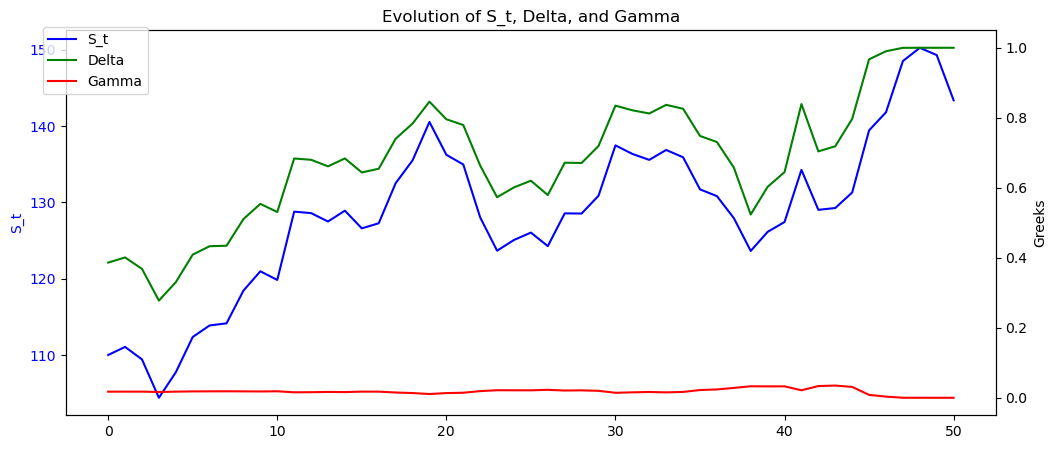

In [16]:
S_path = simulate_MC_path(S0=110, T=1, r=0.05, sigma=0.2, steps=50, div=2, T1=0.5)
dt = 1/50
deltas = [delta(S_t, 125, 1-i*dt, 0.05, 0.2) for i, S_t in enumerate(S_path)]
gammas = [gamma(S_t, 125, 1-i*dt, 0.05, 0.2) for i, S_t in enumerate(S_path)]

fig, ax1 = plt.subplots(figsize=(12,5))

ax1.plot(S_path, color='blue', label='S_t')
ax1.set_ylabel('S_t', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
ax2.plot(deltas, color='green', label='Delta')
ax2.plot(gammas, color='red', label='Gamma')
ax2.set_ylabel('Greeks', color='black')
ax2.tick_params(axis='y', labelcolor='black')

fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.title("Evolution of S_t, Delta, and Gamma")
plt.show()

### 7.2. Visualisation of St, deltas and delta-hedged portfolio value along the differents simulation (via Monte Carlo). 

As well, I thaught it would be better to visualize the paths, deltas and the portfolio on different charts. 

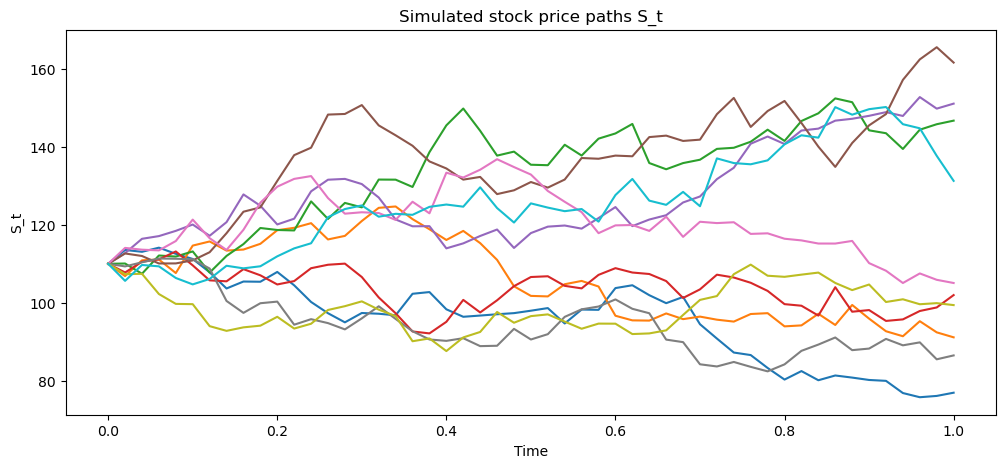

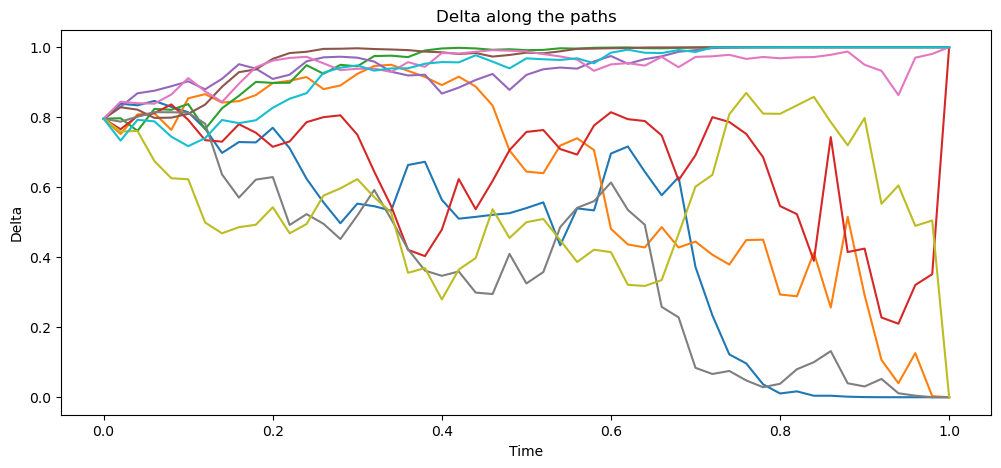

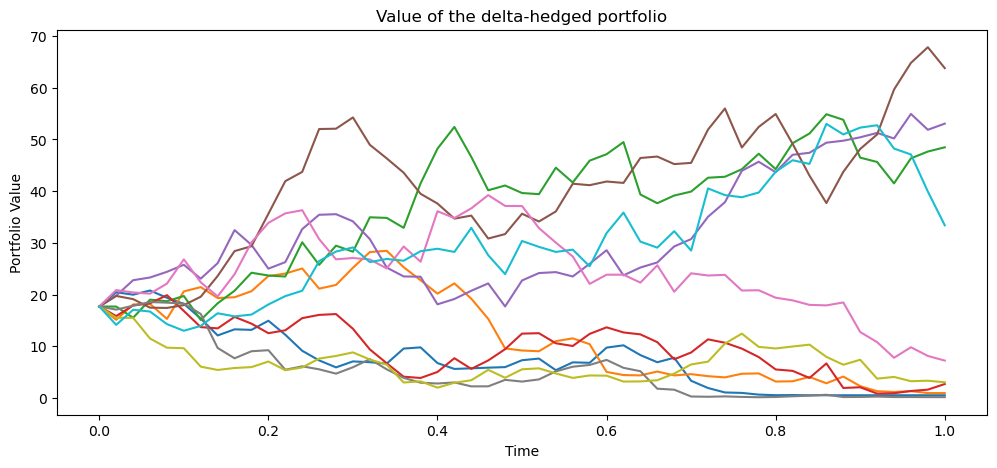

In [17]:
# 1) Parameters

S0 = 110
K = 100
T = 1
r = 0.05
sigma = 0.2
steps = 50
option_type = 'call'
option_style = 'european'
div = 2
T1 = 0.5
N_paths = 50  # on trace moins pour la lisibilité

# 2) Paths and portfolios

results = delta_hedge_all_portfolios(
    S0, K, T, r, sigma, steps, option_type, option_style,
    div=div, T1=T1, N_paths=N_paths
)

S_paths = np.array([res['path'] for res in results])
portfolios = np.array([res['portfolio_values'] for res in results])
deltas = np.array([res['deltas'] for res in results])
final_pnls = np.array([res['final_pnl'] for res in results])

t_grid = np.linspace(0, T, steps+1)

# Visualization of St
plt.figure(figsize=(12,5))
for i in range(min(N_paths,10)):
    plt.plot(t_grid, S_paths[i])
plt.title('Simulated stock price paths S_t')
plt.xlabel('Time')
plt.ylabel('S_t')
plt.show()

# Visualization of Delta
plt.figure(figsize=(12,5))
for i in range(min(N_paths,10)):
    plt.plot(t_grid, deltas[i])
plt.title('Delta along the paths')
plt.xlabel('Time')
plt.ylabel('Delta')
plt.show()

# Visualization of Portefolios

plt.figure(figsize=(12,5))
for i in range(min(N_paths,10)):
    plt.plot(t_grid, portfolios[i])
plt.title('Value of the delta-hedged portfolio')
plt.xlabel('Time')
plt.ylabel('Portfolio Value')
plt.show()


## 8. Convergence test

To **assess the convergence of the delta-hedging Monte Carlo simulation**, we vary both the number of time steps (`steps`) and the number of simulated paths (`N_paths`).  

For each combination of steps and paths, we compute the delta-hedged portfolio's final values using `delta_hedge_MC` and record the **mean** and **standard deviation** of the PnL.  

The printed results allow us to **observe how increasing the number of paths or refining the time discretization affects the accuracy and stability of the hedging strategy**. Ideally, as the number of steps and paths grows, the mean PnL should stabilize closer to zero and the standard deviation should converge, indicating more reliable hedging performance.

In [18]:
N_paths_list = [100, 500, 2000]
steps_list = [10, 50, 200]
results = {}

for steps in steps_list:
    for N_paths in N_paths_list:
        all_portfolios = delta_hedge_MC(
            S0=110, K=100, T=1, r=0.05, sigma=0.2,
            steps=steps, option_type='call', option_style='european',
            epsilon=1e-4, div=2, T1=0.5, N_paths=N_paths
        )
        results[(steps, N_paths)] = (all_portfolios.mean(), all_portfolios.std())

# Affichage
for key, value in results.items():
    print(f"Steps: {key[0]}, Paths: {key[1]} -> Mean PnL: {value[0]:.2f}, Std PnL: {value[1]:.2f}")


Steps: 10, Paths: 100 -> Mean PnL: 19.73, Std PnL: 21.87
Steps: 10, Paths: 500 -> Mean PnL: 18.25, Std PnL: 18.36
Steps: 10, Paths: 2000 -> Mean PnL: 18.09, Std PnL: 19.27
Steps: 50, Paths: 100 -> Mean PnL: 20.70, Std PnL: 20.52
Steps: 50, Paths: 500 -> Mean PnL: 19.15, Std PnL: 18.68
Steps: 50, Paths: 2000 -> Mean PnL: 18.51, Std PnL: 19.53
Steps: 200, Paths: 100 -> Mean PnL: 18.74, Std PnL: 19.00
Steps: 200, Paths: 500 -> Mean PnL: 18.46, Std PnL: 18.95
Steps: 200, Paths: 2000 -> Mean PnL: 18.27, Std PnL: 19.74


## **Conclusion**

In this project, I developed a comprehensive framework to **price, analyze, and hedge vanilla equity options** using a combination of **analytical models**, **numerical methods**, and **Monte Carlo simulations**. Starting from the **Black–Scholes–Merton (BSM) model**, I established a theoretical benchmark for European option pricing and analytical Greeks, which served as a reference throughout the study.

We then extended the pricing methodology by implementing **binomial tree models (CRR)**, allowing us to handle **American-style options** and **discrete dividend payments**, two key features commonly encountered in real equity markets. This step highlighted the importance of the **option style** and **dividend structure** in both pricing and sensitivity analysis.

Building on these pricing tools, we implemented a **Monte Carlo simulation framework** to generate stochastic stock price paths under a geometric Brownian motion. These paths were used to construct and analyze **delta-hedged portfolios**, with dynamic rebalancing over time. By studying the **distribution of final PnL**, we were able to assess the effectiveness and limitations of delta hedging in a discrete-time setting.

A significant part of the project focused on **visualization and diagnostics**. By jointly visualizing the evolution of **stock prices**, **Greeks (delta and gamma)**, and **portfolio values** across multiple simulated paths, we gained deeper insight into the mechanics of hedging and the sources of residual risk. The convergence analysis further emphasized the trade-off between **computational cost** and **hedging accuracy**, especially when increasing the number of time steps and Monte Carlo paths.

Overall, this project demonstrates how classical option pricing theory translates into **practical hedging strategies**, while also illustrating the **model risk**, **discretization error**, and **computational challenges** inherent to numerical implementations. The framework developed here provides a solid foundation for further extensions, such as **volatility smiles**, **transaction costs**, or **alternative stochastic models**, and serves as a robust introduction to **quantitative derivatives modeling in practice**.


## **Limitations and Possible Extensions**

This study assumes constant volatility, frictionless markets, and continuous rebalancing in theory. In practice, discrete hedging, transaction costs, and model misspecification introduce residual risk. Future extensions could include stochastic volatility models, transaction costs, alternative hedging strategies, or calibration to market data.

